# Maximizing loss to decrease perceptual similarity

This experiment decreases the perceptual similarity between a stylized image and a reference image.

1. Choose a reference image.
2. Decrease the perceptual similarity between that reference image and an optimized version of the reference image for a chosen number of iterations.
3. Stylize optimized image to decrease edges detectable by CNNs.


In [ ]:
!pip install torch torchvision lpips pointillism opencv-python-headless retinaface-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import modules

Reload updated modules.

In [ ]:
import lpips
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import pointillism as pt
from PIL import Image
from retinaface.pre_trained_models import get_model



In [ ]:
#Utility functions

def compute_lpips(ref, pred):
    """Function computing perceptual loss."""
    loss_fn_vgg = lpips.LPIPS(net='vgg')
    result = loss_fn_vgg(ref,pred)
    return result

def create_tensor(ref_path, pred_path):
    """Function converting image paths to tensors of the image at that path."""
    ref = lpips.im2tensor(lpips.load_image(ref_path))
    pred = Variable(lpips.im2tensor(lpips.load_image(pred_path)), requires_grad=True)
    return (ref,pred)

def maximize_loss(ref_path, pred_path):
    """Creating tensors for loss maximization."""
    ref = lpips.im2tensor(lpips.load_image(ref_path))
    pred = Variable(lpips.im2tensor(lpips.load_image(pred_path)), requires_grad=True)
    return (-ref,pred)



def loop(ref, pred, length):
    """Function containing optimization loop."""
    optimizer = torch.optim.Adam([pred,], lr=1e-3, betas=(0.9, 0.999))
    results = []

    for i in range(length):
        loss_fn = lpips.LPIPS(net='vgg')
        dist = loss_fn.forward(pred, ref)
        optimizer.zero_grad()
        dist.backward()
        optimizer.step()
        pred.data = torch.clamp(pred.data, -1, 1)
        results.append([i,dist, ref,pred.data])
        pred.data = torch.clamp(pred.data, -1, 1)

    return results

def natural_image_loop(ref_path, pred_path, length):
    """Maximize loss for natural image."""
    ref, pred = maximize_loss(ref_path, pred_path)
    result = loop(ref, pred, length)
    return result




Create a new image with low perceptual similarity to the reference image.

In [ ]:
iterations = 1
!curl https://raw.githubusercontent.com/enderminyard/private-neural-portraits/main/tests/test.jpg -o test.jpg
reference_image_path = 'test.jpg'
results = natural_image_loop(reference_image_path,reference_image_path,iterations)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  901k  100  901k    0     0  9295k      0 --:--:-- --:--:-- --:--:-- 9295k
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


View the results of decreasing perceptual similarity between an optimized image and a reference image.

The perceptual similarity between these is  tensor([[[[0.8326]]]])


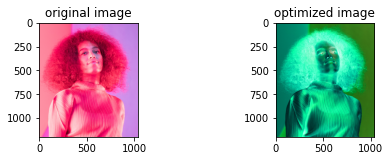

In [ ]:


for result in results:
    iteration, distance, optimized, original = result
    fig = plt.figure(1)
    ax = fig.add_subplot(131)

    ax.imshow(lpips.tensor2im(original))


    img = Image.fromarray(lpips.tensor2im(optimized))
    img.save("output.png")


    ax.set_title('original image')
    ax = fig.add_subplot(133)
    ax.imshow(lpips.tensor2im(optimized))
    ax.set_title('optimized image')
    print("The perceptual similarity between these is ", distance.data)
    


## Add Gaussian blur
The paper titled "LowKey: Leveraging Adversarial Attacks to Protect Social Media Users from Facial Recognition," discusses how Gaussian blur reduces the effectiveness of production face recognition systems.

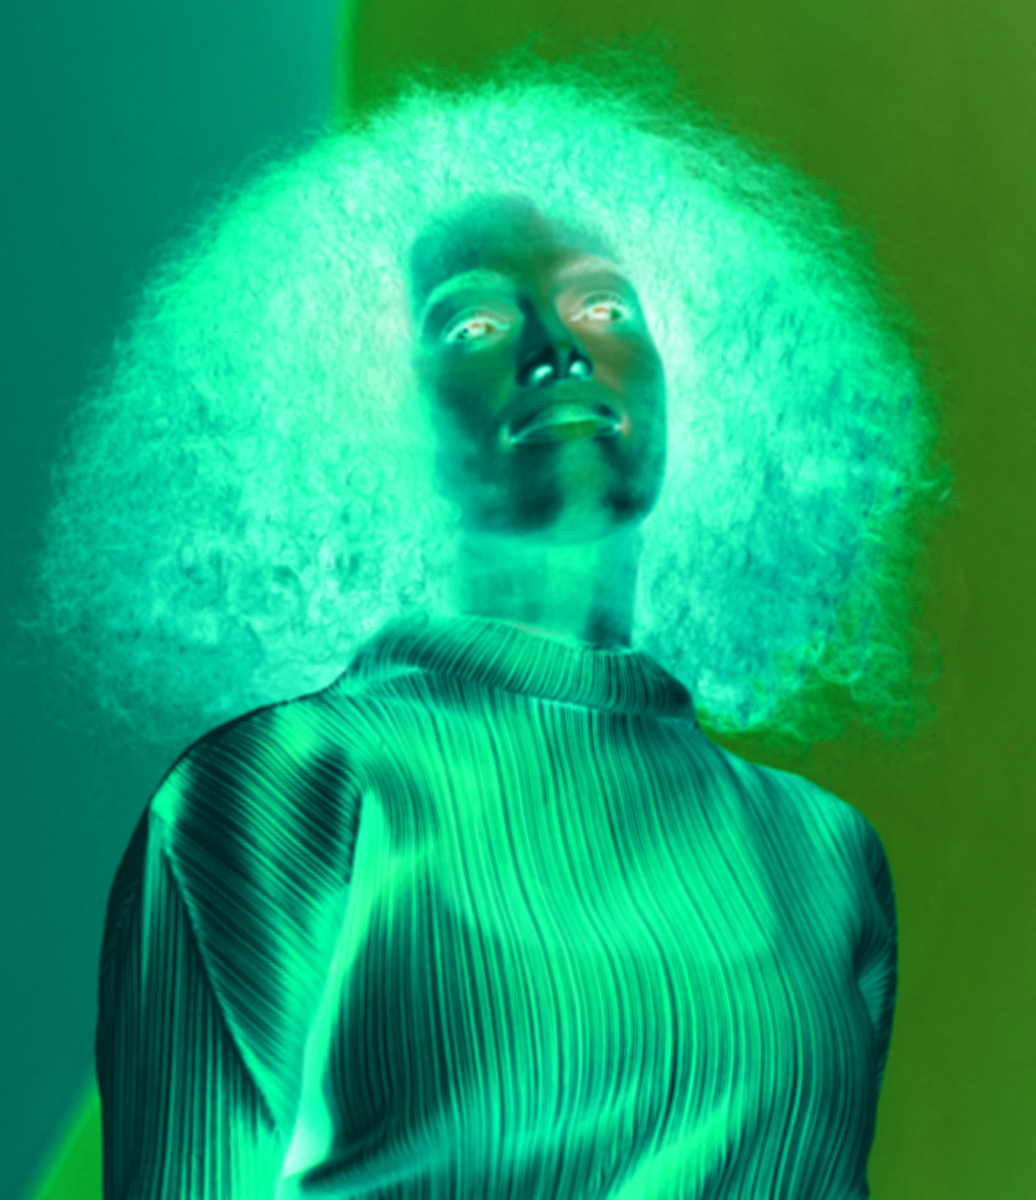

True

In [ ]:
src = cv2.imread('/content/output.png', cv2.IMREAD_UNCHANGED)
dst = cv2.GaussianBlur(src,(5,5),5)

from google.colab.patches import cv2_imshow
cv2_imshow(dst)

cv2.imwrite('/content/output.png',dst)


## Remove edges
We will stylize the resulting image as a pointillist painting to decrease the sharpness of the edges. Convolutional neural networks detect edges.

done in 3.52 seconds
/content/output.png


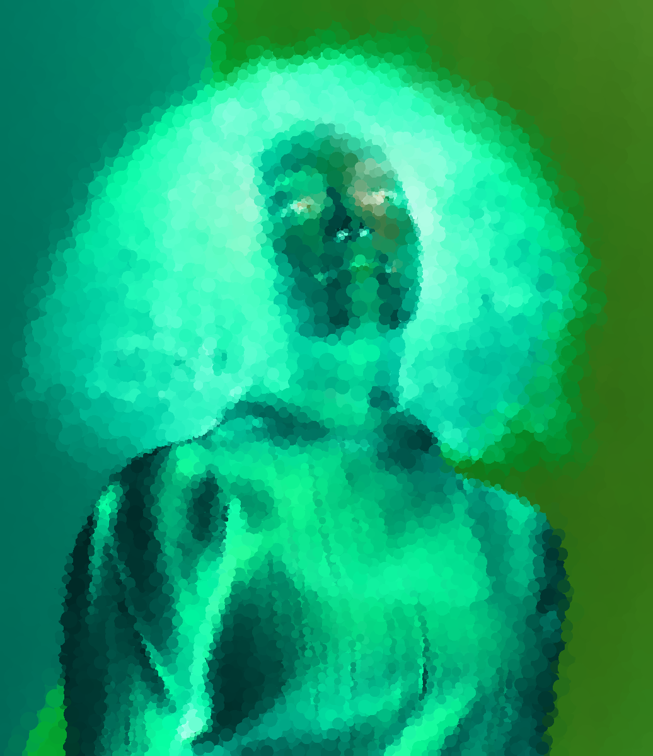

In [ ]:
point = pt.pipeline(location='/content/output.png', debug = True, border = 0)
point.make('fine') 
point.display()
point.save_out('/content/finished') 



## Test facial detection model

Can a face still be detected in the final image?

In [ ]:
model = get_model("resnet50_2020-07-20", max_size=2048)
model.eval()

import numpy 
image = numpy.asarray(Image.open('/content/finished/output.png - pointillized.png'))

annotation = model.predict_jsons(image)
print(annotation)


[{'bbox': [], 'score': -1, 'landmarks': []}]
